Francois Chollet (2017). Deep Learning with Python. Chapter 5

## Environment

# Deep Learning for Computer Vision
* Understanding convolutional neural networks (convnets)
* Using data augmentation to mitigate overfitting
* Using a pretrained convnet to do feature
extraction
* Fine-tuning a pretrained convnet
* Visualizing what convnets learn and how they make classification decisions

## Introduction to Convnets

We will use our convnet to classify MNIST digits. Even though our convnet will be very basic, its accuracy will still blow out of the water that of the densely-connected model (our test accuracy then was 97.8%) 

The 6 lines of code below show you what a basic convnet looks like. `It's a stack of Conv2D and MaxPooling2D layers`. Importantly, a convnet takes as `input tensors of shape (image_height, image_width, image_channels)` (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [1]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Using TensorFlow backend.


Let's display the architecture of our convnet so far:

In [2]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are already familiar with: a stack of `Dense` layers. 

These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the MNIST digits.

In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 2s 0us/step


In [6]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 29s 475us/step - loss: 0.1756 - accuracy: 0.9442
Epoch 2/5
60000/60000 [==============================] - 29s 480us/step - loss: 0.0468 - accuracy: 0.9857
Epoch 3/5
60000/60000 [==============================] - 29s 489us/step - loss: 0.0336 - accuracy: 0.9899
Epoch 4/5
60000/60000 [==============================] - 29s 490us/step - loss: 0.0251 - accuracy: 0.9921
Epoch 5/5
60000/60000 [==============================] - 30s 498us/step - loss: 0.0191 - accuracy: 0.9944


Let's evaluate the model on the test data:

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 157us/step


In [8]:
test_acc

0.9886999726295471

While our densely-connected network had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we decreased our error rate by 68% (relative). 

### The convolution operation

The fundamental difference between a densely connected layer and a convolution layer
* Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels)
* Convolution layers learn local patterns: in the case of images, patterns found in small 2D windows of the inputs. 

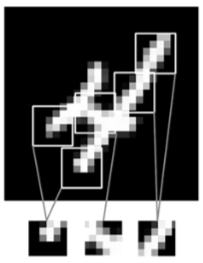

This key characteristic gives convnets two interesting properties:
* `The patterns they learn are translation invariant`. (平移不變性)
    * After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. 
    * A densely connected network would have to learn the pattern anew if it appeared at a new location.
    * This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.
* `They can learn spatial hierarchies of patterns`. (空間層次結構)
    * A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on.
    * This allows convnets to efficiently learn increasingly complex and abstract visual con- cepts (because the visual world is fundamentally spatially hierarchical).

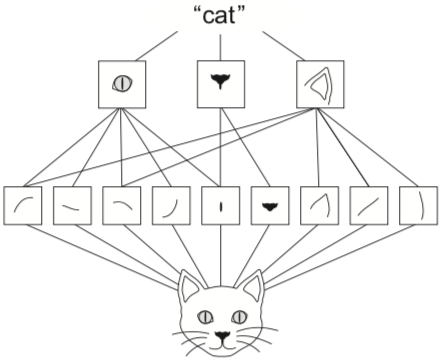

Convolutions operate over 3D tensors, called `feature maps` (特徵映射圖), with two spatial axes (height and width) as well as a depth axis (also called the channels axis).
* For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue.
* For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray).

The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an `output feature map`. 

This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for `filters` (過濾器).
* Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes `32 filters` over its input. Each of these 32 output channels contains a `26 × 26 grid of values`, which is a `response map` (響應圖) of the filter over the input, indicating the response of that filter pattern at different locations in the input

That is what the term `feature map` means: every dimension in the depth axis is a `feature` (or `filter`), and the `2D tensor output[:, :, n]` is the 2D spatial map of the response of this filter over the input.

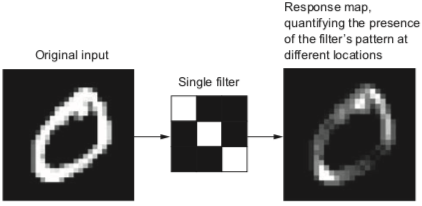

Convolutions are defined by two key parameters:
* `Size of the patches extracted from the inputs`: These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.
* `Depth of the output feature map`—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer: `Conv2D(output_depth, (window_height, window_width))`.

A convolution works by `sliding` (滑動) these windows of size 3 × 3 or 5 × 5 over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of `surrounding features (shape (window_height, window_width, input_depth))`.

Each such 3D patch is then transformed (via a tensor product with the same learned weight matrix, called the `convolution kernel` 卷積核心 ) into `a 1D vector of shape (output_depth,)`.

All of these vectors are then spatially reassembled into `a 3D output map of shape (height, width, output_depth)`.

`Every spatial location in the output feature map corresponds to the same location in the input feature map` (for example, the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with 3 × 3 windows, the vector output [i, j, :] comes from the 3D patch input [i-1 : i+1, j-1 : j+1, :].

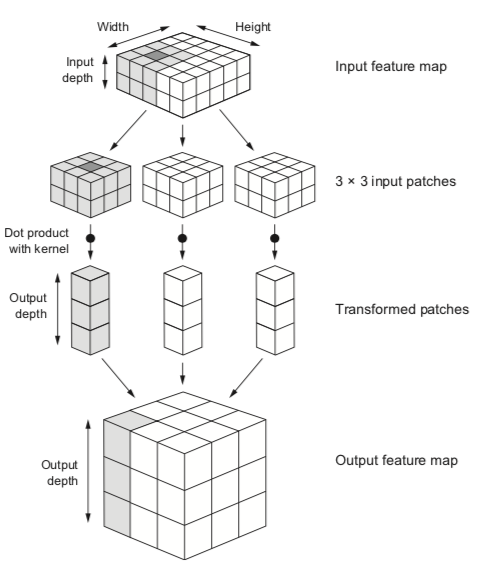

Note that the output width and height may differ from the input width and height. They may differ for two reasons:
* `Border effects` (邊界效應), which can be countered by `padding` the input feature map
* `The use of strides` (步長使用)

#### Understanding border effects and padding

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you can center a 3 × 3 window, forming a 3 × 3 grid. 

Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension, in this case.
* You can see this border effect in action in the earlier example: you start with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

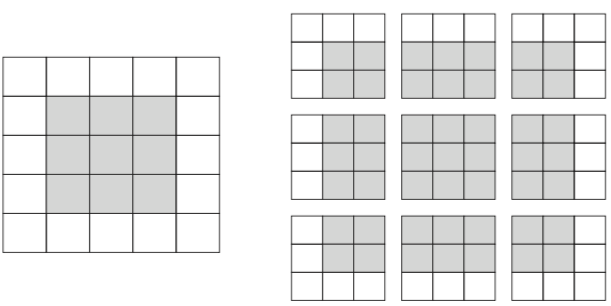

If you want to get `an output feature map with the same spatial dimensions as the input`, you can use `padding` (填補). 

Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile.
* For a 3 × 3 window, you add one column on the right, one column on the left, one row at the top, and one row at the bottom. For a 5 × 5 window, you add two rows

Padding a 5 × 5 input in order to be able to extract 25 3 × 3 patches

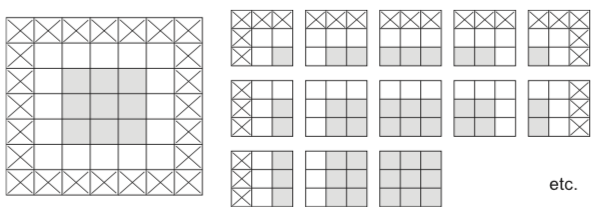

In Conv2D layers, padding is configurable via the `padding argument`, which takes two values: `"valid"`, which means no padding (only valid window locations will be used); and `"same"`, which means “pad in such a way as to have an output with the same width and height as the input.” `The padding argument defaults to "valid"`.

#### Understanding convolution strides

The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But `the distance between two successive windows is a parameter of the convolution`, called its `stride`, which defaults to 1. 

It’s possible to have strided convolutions: convolutions with a stride higher than 1.

You can see the patches extracted by a 3 × 3 convolution with `stride 2` over a 5 × 5 input (without padding).

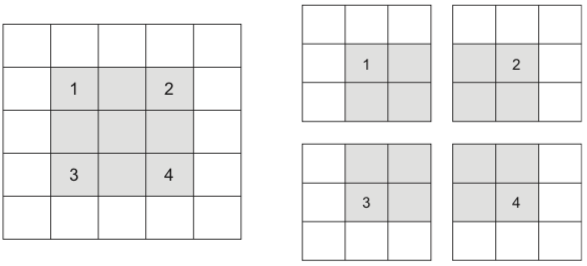

Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). `Strided convolutions are rarely used in practice`, although they can come in handy for some types of models; it’s good to be familiar with the concept.

To downsample feature maps, instead of strides, we tend to use the max-pooling operation,

### The max-pooling operation 

In the convnet example, you may have noticed that the size of the feature maps is halved after every MaxPooling2D layer. 
* For instance, before the first MaxPooling2D lay- ers, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13.

That’s `the role of max pooling`: `to aggressively downsample feature maps`, much like `strided convolutions`.

Max pooling consists of `extracting windows from the input feature maps` and `outputting the max value of each channel`.
* It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the con- volution kernel), they’re transformed via a hardcoded `max tensor operation`. 

A big difference from convolution is that max pooling is usually done with `2 × 2 windows and stride 2`, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1).

Why downsample feature maps this way? Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let’s look at this option. The convo- lutional base of the model would then look like this:

In [9]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [10]:
model_no_max_pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


What’s wrong with this setup? Two things:
* `It isn’t conducive to learning a spatial hierarchy of features.` The 3 × 3 windows in the third layer will only contain information coming from 7 × 7 windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to clas- sify digits (try recognizing a digit by only looking at it through windows that are 7 × 7 pixels!). We need the features from the last convolution layer to contain information about the totality of the input. 
* `The final feature map has 22 × 22 × 64 = 30,976 total coefficients per sample.` `This is huge.` If you were to flatten it to stick a Dense layer of size 512 on top, that layer would have 15.8 million parameters. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downsampling is `to reduce the number of feature-map coefficients to process`, as well as `to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows` (in terms of the fraction of the original input they cover).

Note that `max pooling isn’t the only way you can achieve such downsampling`. As you already know, you can also use `strides` in the prior convolution layer. And you can use `average pooling` instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. 

But `max pooling tends to work better than these alternative solutions.` In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term feature map), and it’s more informative to look at the maximal presence of different features than at their average presence. 

So `the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches`, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

## Training a Convnet from Scratch on a Small Dataset

Having to train an image classification model using only very little data is a common situation. Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images.

As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

### The relevance of deep learning for small-data problems

One fundamental characteristic of deep learning is that it is able to `find interesting features` in the training data on its own, `without any need for manual feature engineering`, and this can only be achieved `when lots of training examples are available`. This is especially true for problems where the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- `relative to the size and depth of the network` you are trying to train.

`Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems.` Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering.

### Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. 

You can download the original dataset at: https://www.kaggle.com/c/dogs-vs-cats/data. The pictures are medium-resolution color JPEGs. They look like this:

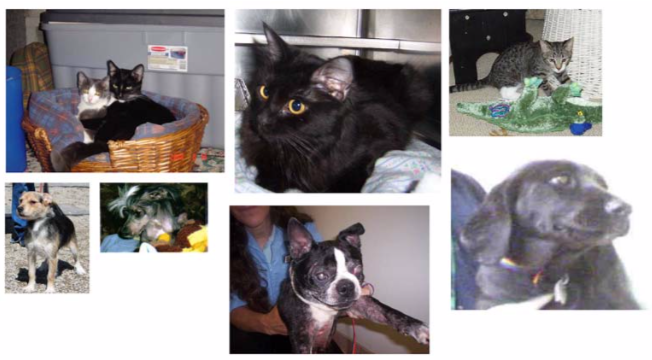

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy.

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

In [11]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('cats_and_dogs_small.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [12]:
import os

base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

### Building your network

Since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more Conv2D + MaxPooling2D stage. This serves both `to augment the capacity of the network`, and `to further reduce the size of the feature maps`, so that `they aren't overly large when we reach the Flatten layer`.
* Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the Flatten layer.

Note that `the depth of the feature maps is progressively increasing` in the network (from 32 to 128), while `the size of the feature maps is decreasing` (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a `binary classification problem`, we are ending the network with `a single unit` (`a Dense layer of size 1`) and `a sigmoid activation`. This unit will encode the probability that the network is looking at one class or the other.

In [13]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

For our compilation step, we'll go with the `RMSprop optimizer` as usual. Since we ended our network with a single sigmoid unit, we will use `binary crossentropy` as our loss

In [15]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:
* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [17]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator method`, the equivalent of fit for data generators like ours. 
* It expects as first argument `a Python generator` that will yield batches of inputs and targets indefinitely, like ours does. 
* Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. 
  - This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 52s 519ms/step - loss: 0.6892 - acc: 0.5400 - val_loss: 0.6549 - val_acc: 0.5810
Epoch 2/30
100/100 [==============================] - 53s 530ms/step - loss: 0.6561 - acc: 0.6165 - val_loss: 0.6431 - val_acc: 0.5600
Epoch 3/30
100/100 [==============================] - 54s 536ms/step - loss: 0.6141 - acc: 0.6615 - val_loss: 0.4767 - val_acc: 0.6540
Epoch 4/30
100/100 [==============================] - 55s 548ms/step - loss: 0.5776 - acc: 0.6970 - val_loss: 0.8475 - val_acc: 0.6640
Epoch 5/30
100/100 [==============================] - 55s 552ms/step - loss: 0.5334 - acc: 0.7400 - val_loss: 0.5180 - val_acc: 0.6730
Epoch 6/30
100/100 [==============================] - 56s 557ms/step - loss: 0.5076 - acc: 0.7515 - val_loss: 0.5214 - val_acc: 0.6790
Epoch 7/30
100/100 [==============================] - 55s 551ms/step - loss: 0.4741 - acc: 0.7710 - val_loss: 0.6173 - val_acc: 0.7080
Epoch 8/30
100/100 [==============================] - 5

It is good practice to always save your models after training:

In [19]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

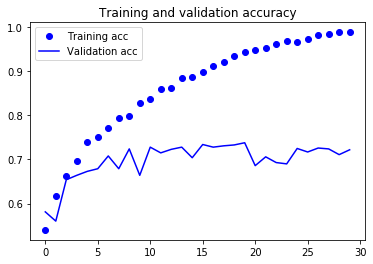

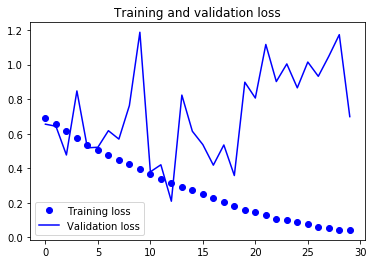

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

`These plots are characteristic of overfitting`. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as `dropout` and `weight decay` (`L2 regularization`). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: `*data augmentation*`.

### Using data augmentation

`Data augmentation` (資料擴增) takes the approach of `generating more training data from existing training samples`, by `"augmenting"` the samples via a number of random transformations that yield believable-looking images. 

The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [21]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available. Let's quickly go over what we just wrote:
* `rotation_range` (旋轉) is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift and height_shift` (垂直和水平平移) are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` (傾斜) is for randomly applying shearing transformations.
* `zoom_range` (縮放) is for randomly zooming inside pictures.
* `horizontal_flip` (水平翻轉) is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* `fill_mode` (填滿) is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images

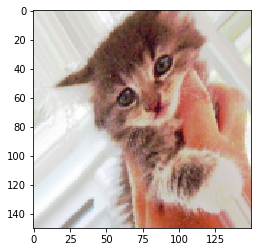

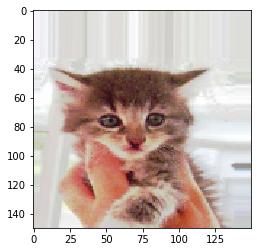

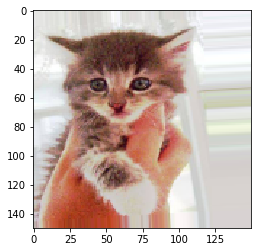

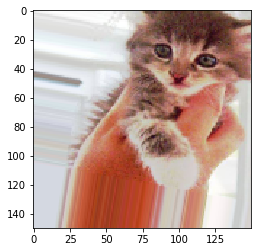

In [22]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting.

To further fight overfitting, we will also add `a Dropout layer` to our model, right before the densely-connected classifier:

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 90s 903ms/step - loss: 0.6911 - acc: 0.5240 - val_loss: 0.6891 - val_acc: 0.4987
Epoch 2/100
100/100 [==============================] - 91s 905ms/step - loss: 0.6814 - acc: 0.5512 - val_loss: 0.6782 - val_acc: 0.5986
Epoch 3/100
100/100 [==============================] - 91s 906ms/step - loss: 0.6636 - acc: 0.6020 - val_loss: 0.6834 - val_acc: 0.6148
Epoch 4/100
100/100 [==============================] - 91s 912ms/step - loss: 0.6526 - acc: 0.6146 - val_loss: 0.5493 - val_acc: 0.6463
Epoch 5/100
100/100 [==============================] - 91s 910ms/step - loss: 0.6319 - acc: 0.6313 - val_loss: 0.6548 - val_acc: 0.6739
Epoch 6/100
100/100 [==============================] - 92s 920ms/step - loss: 0.6152 - acc: 0.6573 - val_loss: 0.5864 - val_acc: 0.6978
Epoch 7/100
100/100 [==============================] - 91s 912ms/step - loss: 0.6028 - acc: 0.6736 -

Let's save our model -- we will be using it in the section on convnet visualization.

In [25]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

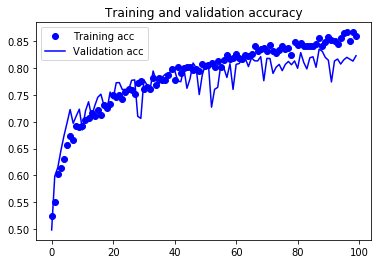

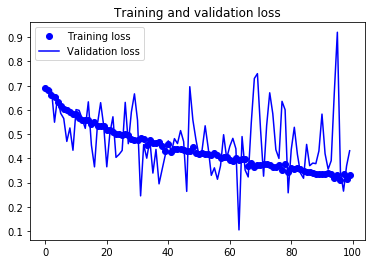

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to `data augmentation and dropout`, we are `no longer overfitting`: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By `leveraging regularization techniques even further` and by `tuning the network's parameters` (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. 

As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two sections.

## Using a Pretrained Convnet

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network.

A `pretrained network` is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task. 
* For instance, you might train a network on `ImageNet` (where `classes are mostly animals and everyday objects`) and then repurpose this trained network for something as remote as `identifying furniture items` in images.
* Such `portability of learned features across different problems` is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider `a large convnet trained on the ImageNet dataset` (`1.4 million labeled images and 1,000 different classes`). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.

We’ll use `the VGG16 architecture`, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.1 Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, its architecture is similar to what you’re already familiar with and is easy to understand without introducing any new concepts.

There are two ways to use a pretrained network: 
* feature extraction
* fine-tuning

### Feature extraction

`Feature extraction` consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called `the convolutional base` of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.


![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

The representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of `generic concepts` over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier will necessarily be `specific to the set of classes` on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture.

Additionally, representations found in densely connected layers no longer contain any information about `where objects are located in the input image`: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model.

Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”).

So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

`The VGG16 model`, among others, comes prepackaged with Keras. You can import it from `the keras.applications module`. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras .applications:
* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

In [27]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 3s 0us/step


You pass three arguments to the constructor:
* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
* `input_shape` is the shape of the image tensors that you’ll feed to the network.This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* `Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier`
    - This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.
* `Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data.` 
    - This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

#### Fast feature extraction without data augementation

Let's walk through the code required to set-up the first one: recording the output of conv_base on our data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the conv_base model.

In [29]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):

In [30]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [31]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5895 - acc: 0.6660 - val_loss: 0.4464 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 2s 913us/step - loss: 0.4261 - acc: 0.8150 - val_loss: 0.3748 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 2s 803us/step - loss: 0.3623 - acc: 0.8445 - val_loss: 0.3280 - val_acc: 0.8690
Epoch 4/30
2000/2000 [==============================] - 2s 865us/step - loss: 0.3293 - acc: 0.8690 - val_loss: 0.3027 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 2s 935us/step - loss: 0.2917 - acc: 0.8790 - val_loss: 0.2877 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 2s 935us/step - loss: 0.2668 - acc: 0.9040 - val_loss: 0.2760 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 2s 914us/step - loss: 0.2533 - acc: 0.8990 - val_loss: 0.2725 - val_acc: 0.8920
Ep

Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

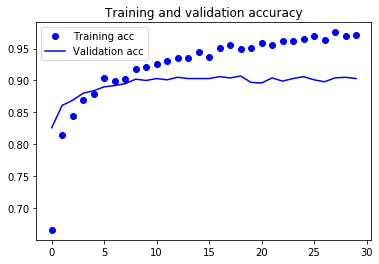

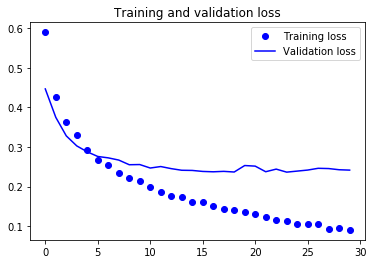

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are `overfitting almost from the start` -- despite using dropout with a fairly large rate. This is `because this technique does not leverage data augmentation`, which is essential to preventing overfitting with small image datasets.

#### Feature extraction with data augementation 

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that `you should only attempt it if you have access to a GPU`: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can `add a model (like our conv_base) to a Sequential model` just like you would add a layer. So you can do the following:

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to `freeze (凍結) the convolutional base`. `"Freezing" a layer or set of layers means preventing their weights from getting updated during training.` If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [35]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [36]:
conv_base.trainable = False

In [37]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (`the main weight matrix` and `the bias vector`). 

Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [38]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 283s 3s/step - loss: 0.5924 - acc: 0.6865 - val_loss: 0.4916 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 279s 3s/step - loss: 0.4812 - acc: 0.7855 - val_loss: 0.4016 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 284s 3s/step - loss: 0.4322 - acc: 0.8060 - val_loss: 0.5663 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 280s 3s/step - loss: 0.4046 - acc: 0.8220 - val_loss: 0.2391 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 280s 3s/step - loss: 0.3921 - acc: 0.8260 - val_loss: 0.4202 - val_acc: 0.8590
Epoch 6/30
100/100 [==============================] - 279s 3s/step - loss: 0.3640 - acc: 0.8395 - val_loss: 0.3234 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 278s 3s/step - loss: 0.3547 - acc: 0.8450 - val_loss: 0.3495 - v

In [39]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

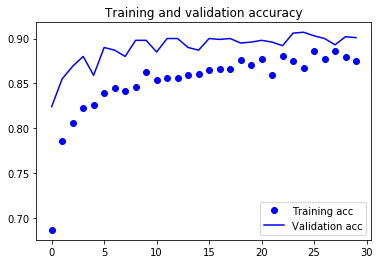

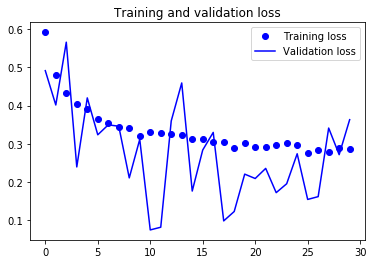

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

#### Fine-tuning

`Fine-tuning` consists in `unfreezing a few of the top layers of a frozen model base used for feature extraction`, and `jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers`. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, `it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained.` If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed.

Thus the steps for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our conv_base, and then freeze individual layers inside of it.

In [41]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* `Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features.` It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* `The more parameters we are training, the more we are at risk of overfitting.` The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base. Let's set this up, starting from where we left off in the previous example:

In [42]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the `RMSprop optimizer`, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 326s 3s/step - loss: 0.3119 - acc: 0.8630 - val_loss: 0.1526 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 325s 3s/step - loss: 0.2628 - acc: 0.8840 - val_loss: 0.0670 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 326s 3s/step - loss: 0.2333 - acc: 0.8990 - val_loss: 0.1387 - val_acc: 0.9280
Epoch 4/100
100/100 [==============================] - 326s 3s/step - loss: 0.2247 - acc: 0.9075 - val_loss: 0.1184 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 327s 3s/step - loss: 0.2208 - acc: 0.9090 - val_loss: 0.3974 - val_acc: 0.9140
Epoch 6/100
100/100 [==============================] - 328s 3s/step - loss: 0.1972 - acc: 0.9240 - val_loss: 0.3515 - val_acc: 0.9070
Epoch 7/100
100/100 [==============================] - 328s 3s/step - loss: 0.1690 - acc: 0.9300 - val_loss: 0.1825 - val_acc: 0.9250
Epoch 8/100
100/100 [==============================] - 328s 3s

In [44]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

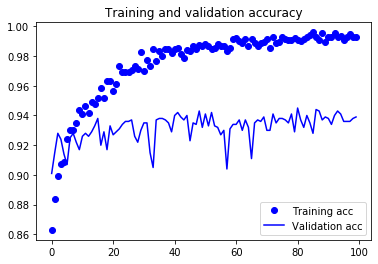

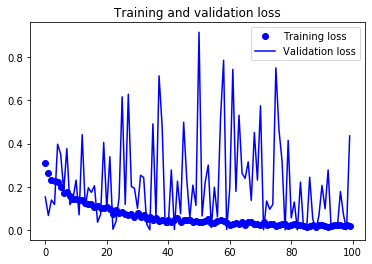

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

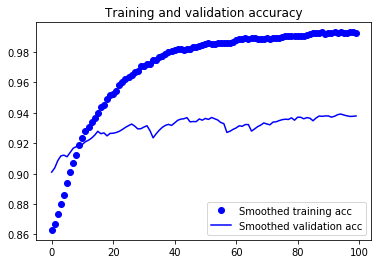

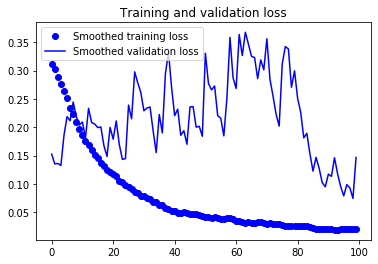

In [46]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look much cleaner and more stable. We are seeing `a nice 1% absolute improvement`.

`Note that the loss curve does not show any real improvement` (in fact, it is deteriorating). You may wonder, how could accuracy improve if the loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [47]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9380000233650208


Here we get `a test accuracy of 97%`. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using `only a very small fraction of the training data available (about 10%)`. There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

### Wrapping up

Here's what you should take away from the exercises of these past two sections:

* `Convnets` are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
* `On a small dataset, overfitting will be the main issue`. `Data augmentation` is a powerful way to fight overfitting when working with image data.
* `It is easy to reuse an existing convnet on a new dataset`, via `feature extraction`. This is a very valuable technique for working with small image datasets.
* As a complement to feature extraction, one may use `fine-tuning`, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

## Visualizing What CNN Learn

It’s often said that deep-learning models are `“black boxes”`: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, `it’s definitely not true for convnets`. 

The representations learned by convnets are highly amenable to visualiza- tion, in large part because they’re `representations of visual concepts`.

We’ll cover three of the most accessible and useful ones:
* `Visualizing intermediate convnet outputs (intermediate activations)`
    * Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* `Visualizing convnets filters`
    * Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* `Visualizing heatmaps of class activation in an image`
    * Useful for understanding which parts of an image were identified as belonging to a given class, thus allow- ing you to localize objects in images.

### Visualizing intermediate activations

Visualizing intermediate activations consists of `displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input` (the output of a layer is often called its `activation`, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. 

You want to visualize feature maps with `three dimensions: width, height, and depth (channels)`. `Each channel encodes relatively independent features`, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Using TensorFlow backend.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)      

Next, you’ll get an input image — a picture of a cat, not part of the images the network was trained on.

In [2]:
img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

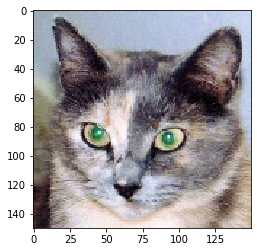

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. 

we will use the Keras class `Model`. A Model is instantiated using two arguments: `an input tensor (or list of input tensors)`, and `an output tensor (or list of output tensors)`. The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs.

In [4]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. In the general case, a` model could have any number of inputs and outputs`. This one has one input and 8 outputs, one output per layer activation.

In [5]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

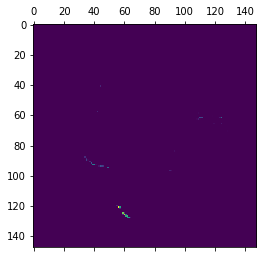

In [7]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a `diagonal edge detector`. Let's try the 30th channel -- but note that your own channels may vary, since the specific filters learned by convolution layers are not deterministic.

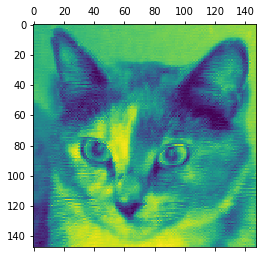

In [8]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This one looks like a `"bright green dot" detector`, useful to encode cat eyes. At this point, let's go and plot a complete visualization of all the activations in the network.

We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in one big image tensor, with channels stacked side by side.

/Users/lunghaolee/Documents/anaconda3/envs/pdl/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


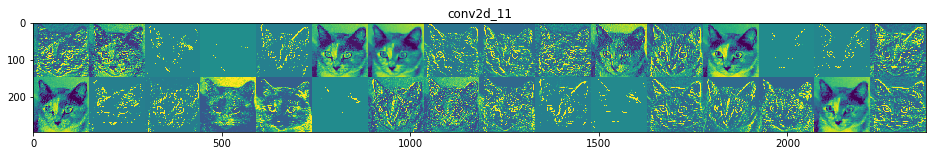

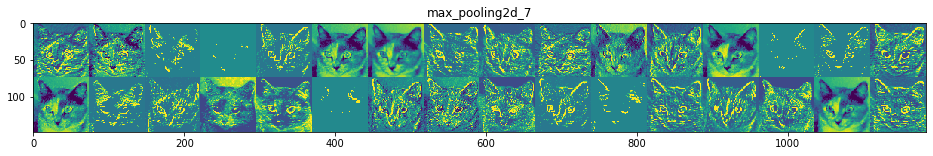

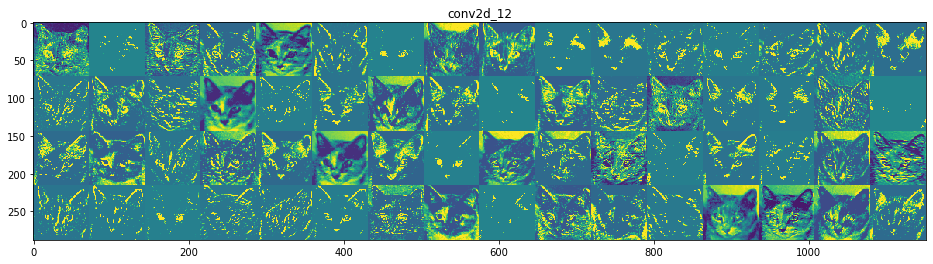

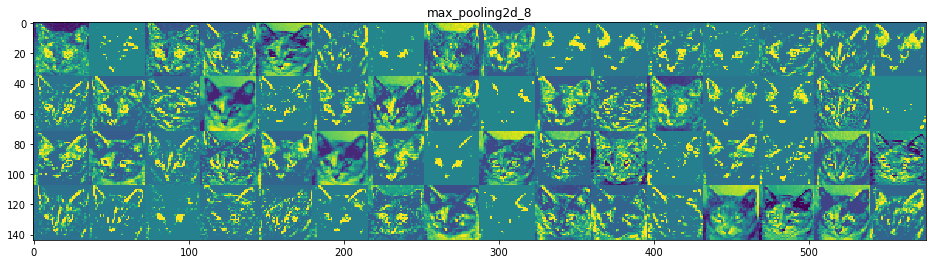

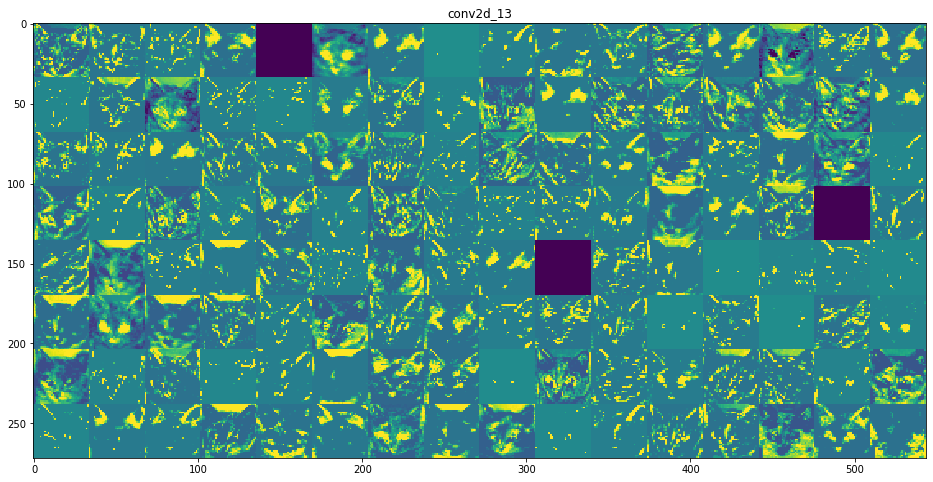

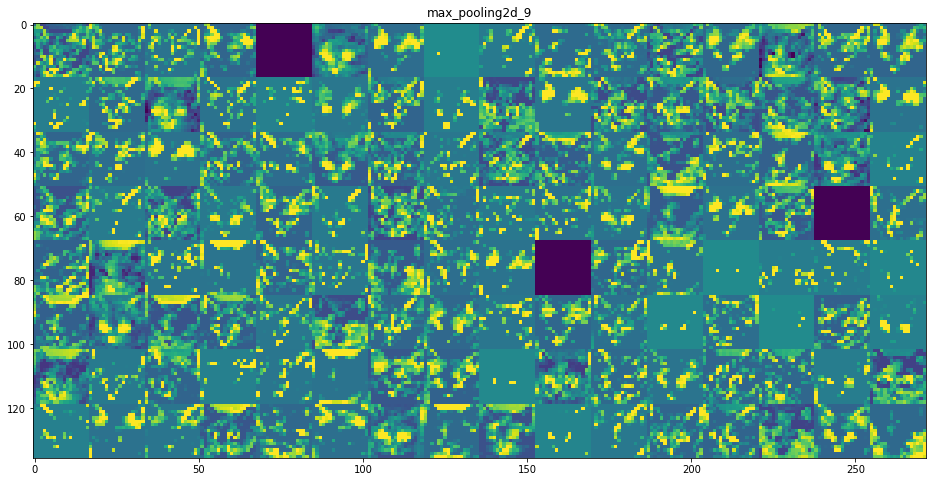

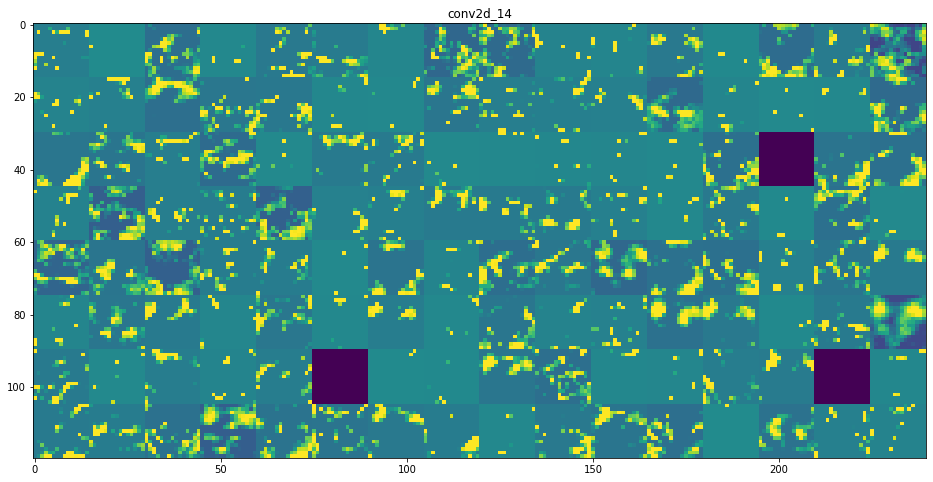

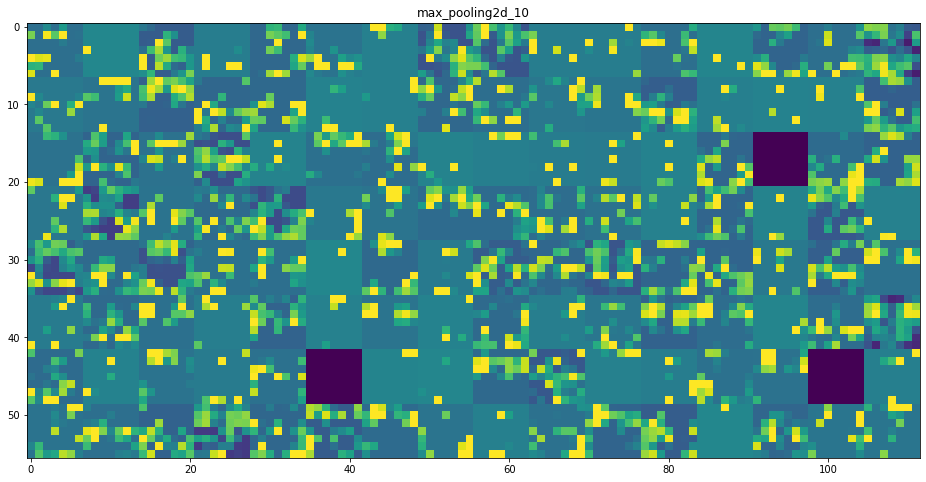

In [9]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* `The first layer acts as a collection of various edge detectors.` At that stage, the activations are still retaining almost all of the information present in the initial picture.
* `As we go higher-up, the activations become increasingly abstract and less visually interpretable.` They start encoding higher-level concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* `The sparsity of the activations is increasing with the depth of the layer`: in the first layer, all filters are activated by the input image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the input image.

A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in our case, RBG pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: You brain has learned to completely abstract its visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it tremendously difficult to remember how things around us actually look.

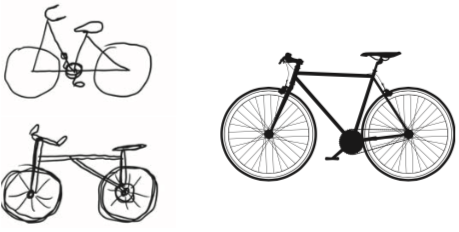

### Visualizing convnet filters

Another easy thing to do to inspect the filters learned by convnets is to `display the visual pattern that each filter is meant to respond to`.

This can be done with `gradient ascent in input space`: applying `gradient descent` to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value.

For instance, here's a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [10]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the `gradients` function packaged with the `backend` module of Keras:

In [11]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within a same range.

In [12]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend function to do this: `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

In [13]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent:

In [14]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape (1, 150, 150, 3), with values that may not be integer within [0, 
255]. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward utility function:

In [15]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

In [16]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

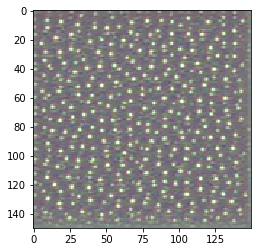

In [17]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in layer block3_conv1 is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at `the first 64 filters in each layer`, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

Filter patterns for layer block1_conv1

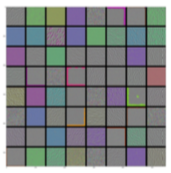

Filter patterns for layer block2_conv1

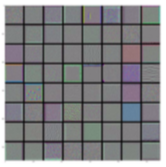

Filter patterns for layer block3_conv1

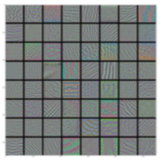

Filter patterns for layer block4_conv1

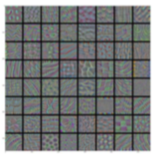

`These filter visualizations tell us a lot about how convnet layers see the world`: each layer in a convnet simply learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. 

`The filters in these convnet filter banks get increasingly complex and refined as we go higher-up in the model`:
* The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges in some cases).
* The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

### Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for `understanding which parts of a given image led a convnet to its final classification decision`.

This general category of techniques is called `"Class Activation Map" (CAM) visualization`, and consists in `producing heatmaps of "class activation" over input images`. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered.
* For instance, given a image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the image are.

The specific implementation we will use is the one described in `Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization`. It is very simple: it consists in taking the output feature map of a convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. 

We will demonstrate this technique using the pre-trained VGG16 network again:

In [18]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [19]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)


In [20]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.89544886), ('n01871265', 'tusker', 0.09967599), ('n02504013', 'Indian_elephant', 0.0046395455)]


The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [21]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [22]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

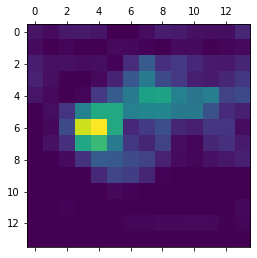

In [23]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use `OpenCV` to generate an image that superimposes the original image with the heatmap we just obtained:

In [24]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

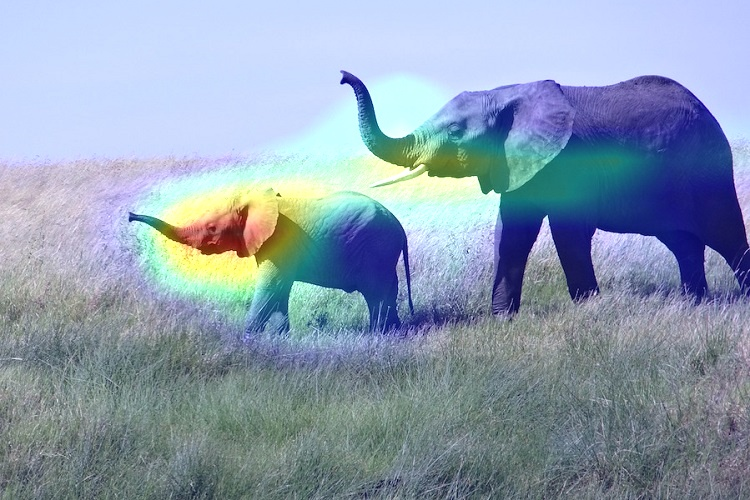

In [25]:
from IPython.display import Image
Image(filename='elephant_cam.jpg') 